In [28]:
import os 
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, RocCurveDisplay, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


import joblib

In [13]:
data_path = '../data/processed/churn_ready.csv'
df_prot = pd.read_csv(data_path)

In [17]:
#fixing categorical variables
df_prot = pd.get_dummies(df_prot, columns=['AgeGroup', 'TenureGroup'], drop_first=True)

In [18]:
X = df_prot.drop('Exited', axis=1)
y = df_prot['Exited']

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.25, random_state=42)

In [ ]:
#baseline model

param_baseline = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)

random_base = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_baseline,
    n_iter=20,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)

random_base.fit(X_train, y_train)

y_pred_base = random_base.predict(X_test)

baseline_f1score = f1_score(y_test, y_pred_base)
baseline_rocauc =  roc_auc_score(y_test, random_base.predict_proba(X_test)[:, 1])

print("Best Params: ", random_base.best_params_)
print("F1:", baseline_f1score)
print("AUC-ROC:",baseline_rocauc)


Best Params:  {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
F1: 0.5739130434782609
AUC-ROC: 0.8631498916045584


In [ ]:
# class_weight - balanced model

param_balanced = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

random_balanced = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_balanced,
    n_iter=20,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)

random_balanced.fit(X_train, y_train)

y_pred_balanced = random_balanced.predict(X_test)

balanced_f1score = f1_score(y_test, y_pred_balanced)
balanced_rocauc =  roc_auc_score(y_test, random_balanced.predict_proba(X_test)[:, 1])

print("Best Params: ", random_balanced.best_params_)
print("F1:", balanced_f1score)
print("AUC-ROC:", balanced_rocauc)

Best Params:  {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10, 'class_weight': 'balanced'}
F1: 0.6221408966148216
AUC-ROC: 0.8715950658118705


In [21]:
#under-sampling model

def random_undersample(X, y, random_state=None):

    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)

    np.random.seed(random_state)

    # Contar os exemplos de cada classe
    class_counts = y.value_counts()
    min_class = class_counts.idxmin()
    min_count = class_counts.min()

    # Coletar os índices da classe minoritária
    indices_to_keep = y[y == min_class].index.tolist()

    # Para as outras classes, fazer undersampling
    for cls in class_counts.index:
        if cls != min_class:
            cls_indices = y[y == cls].index.tolist()
            sampled_indices = np.random.choice(cls_indices, min_count, replace=False)
            indices_to_keep.extend(sampled_indices)

    # Embaralhar os índices selecionados
    np.random.shuffle(indices_to_keep)

    # Retornar os dados balanceados
    X_resampled = X.loc[indices_to_keep].reset_index(drop=True)
    y_resampled = y.loc[indices_to_keep].reset_index(drop=True)

    return X_resampled, y_resampled

X_res, y_res = random_undersample(X, y, random_state=42)

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.25, random_state=42)

random_undsamp = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_baseline,
    n_iter=20,
    cv=5, 
    scoring='f1',
    n_jobs=-1,
    random_state=42
)

random_undsamp.fit(Xr_train, yr_train)

y_pred_undsamp = random_undsamp.predict(Xr_test)
undsamp_f1score = f1_score(yr_test, y_pred_undsamp)
undsamp_rocauc =  roc_auc_score(yr_test, random_undsamp.predict_proba(Xr_test)[:, 1])

print("Best Params: ", random_undsamp.best_params_)
print("F1:", undsamp_f1score)
print("AUC-ROC:", undsamp_rocauc)

Best Params:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}
F1: 0.7781036168132942
AUC-ROC: 0.8595053738587773


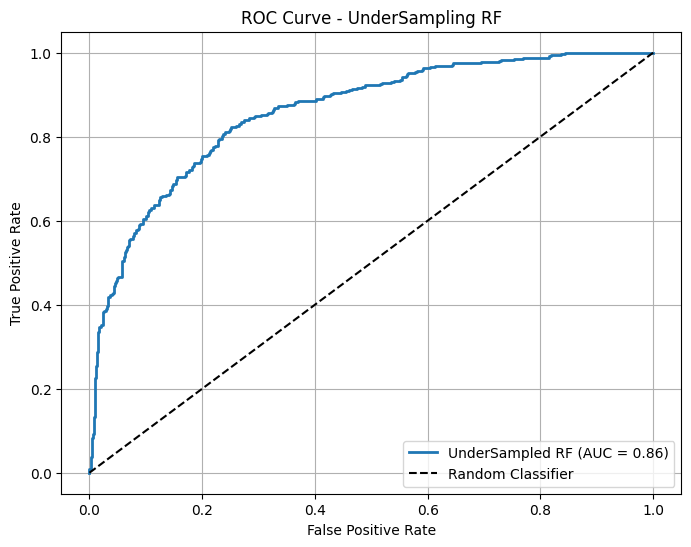

In [29]:
y_probs = random_undsamp.predict_proba(Xr_test)[:, 1]
fpr, tpr, thresholds = roc_curve(yr_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'UnderSampled RF (AUC = {undsamp_rocauc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - UnderSampling RF')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [26]:
#Logistic Regression baseline model

lr = LogisticRegression(max_iter=1000, random_state=42)

param_dist_lr = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': np.logspace(-4, 4, 20),
    'solver': ['saga'],
    'l1_ratio': np.linspace(0, 1, 10)  # só usado se penalty='elasticnet'
}

random_search_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist_lr,
    n_iter=30,
    cv=5,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

random_search_lr.fit(X_train, y_train)

best_lr = random_search_lr.best_estimator_

y_pred_lr = best_lr.predict(X_test)
y_prob_lr = best_lr.predict_proba(X_test)[:, 1]

print("Best Params:", random_search_lr.best_params_)
print("F1-score:", f1_score(y_test, y_pred_lr))
print("AUC-ROC:", roc_auc_score(y_test, y_prob_lr))

Best Params: {'solver': 'saga', 'penalty': 'l1', 'l1_ratio': np.float64(0.4444444444444444), 'C': np.float64(1438.44988828766)}
F1-score: 0.44804318488529016
AUC-ROC: 0.8064196546541953


In [ ]:
lr_balanced = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)


param_lr = {
    'C': np.logspace(-3, 3, 20),
    'penalty': ['l1', 'l2']
}

# 3. RandomizedSearchCV
lr_search = RandomizedSearchCV(
    estimator=lr_balanced,
    param_distributions=param_lr,
    n_iter=20,
    cv=5,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)


lr_search.fit(X_train, y_train)


y_pred_lr_bal = lr_search.predict(X_test)
f1_lr_bal = f1_score(y_test, y_pred_lr_bal)
roc_auc_lr_bal = roc_auc_score(y_test, lr_search.predict_proba(X_test)[:, 1])


print("Best Params:", lr_search.best_params_)
print("F1 Score:", f1_lr_bal)
print("AUC-ROC:", roc_auc_lr_bal)

Best Params: {'penalty': 'l2', 'C': np.float64(483.2930238571752)}
F1 Score: 0.5345687811831789
AUC-ROC: 0.8057012943313674


In [ ]:
# undersampling
X_res_lr, y_res_lr = random_undersample(X, y, random_state=42)


Xlr_train, Xlr_test, ylr_train, ylr_test = train_test_split(
    X_res_lr, y_res_lr,
    stratify=y_res_lr,
    test_size=0.25,
    random_state=42
)


lr_undersampled = LogisticRegression(solver='liblinear', random_state=42)


param_lr = {
    'C': np.logspace(-3, 3, 20),
    'penalty': ['l1', 'l2']
}


lr_undersampling_search = RandomizedSearchCV(
    estimator=lr_undersampled,
    param_distributions=param_lr,
    n_iter=20,
    cv=5,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

lr_undersampling_search.fit(Xlr_train, ylr_train)


y_pred_lr_under = lr_undersampling_search.predict(Xlr_test)
f1_lr_under = f1_score(ylr_test, y_pred_lr_under)
roc_auc_lr_under = roc_auc_score(ylr_test, lr_undersampling_search.predict_proba(Xlr_test)[:, 1])


print("Best Params:", lr_undersampling_search.best_params_)
print("F1 Score:", f1_lr_under)
print("AUC-ROC:", roc_auc_lr_under)

Best Params: {'penalty': 'l2', 'C': np.float64(0.07847599703514611)}
F1 Score: 0.7157057654075547
AUC-ROC: 0.7943025540275049


In [34]:
X_res_svc, y_res_svc = random_undersample(X, y, random_state=42)


Xs_train, Xs_test, ys_train, ys_test = train_test_split(
    X_res_svc, y_res_svc,
    stratify=y_res_svc,
    test_size=0.25,
    random_state=42
)


svc = SVC(probability=True)

param_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# 4. RandomizedSearchCV
svc_search = RandomizedSearchCV(
    estimator=svc,
    param_distributions=param_svc,
    n_iter=10,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)


svc_search.fit(Xs_train, ys_train)


y_pred_svc = svc_search.predict(Xs_test)
f1_svc = f1_score(ys_test, y_pred_svc)
roc_auc_svc = roc_auc_score(ys_test, svc_search.predict_proba(Xs_test)[:, 1])

print("Best Params:", svc_search.best_params_)
print("F1 Score:", f1_svc)
print("AUC-ROC:", roc_auc_svc)

Best Params: {'kernel': 'rbf', 'gamma': 'auto', 'C': 10}
F1 Score: 0.7558257345491388
AUC-ROC: 0.8465869255364229


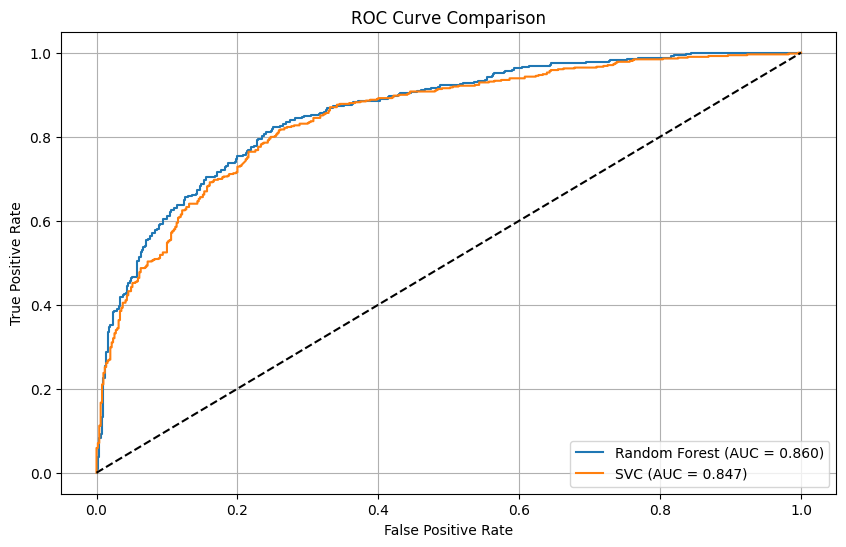

In [35]:
fpr_rf, tpr_rf, _ = roc_curve(yr_test, random_undsamp.predict_proba(Xr_test)[:, 1])
fpr_svc, tpr_svc, _ = roc_curve(ys_test, svc_search.predict_proba(Xs_test)[:, 1])

plt.figure(figsize=(10,6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.3f})'.format(undsamp_rocauc))
plt.plot(fpr_svc, tpr_svc, label='SVC (AUC = {:.3f})'.format(roc_auc_svc))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Model Comparison: Random Forest vs. SVC (Undersampling Strategy)

Two distinct models using the same undersampling technique to address the class imbalance in the dataset had similar performances: Random Forest (tree-based ensemble) and Support Vector Classifier (kernel-based). 

## Key Findings:
Both models performed well, showing strong F1-scores and high AUC-ROC values, indicating good balance between precision and recall and strong classification capability.

The Random Forest slightly outperformed SVC in both metrics.

Random Forest is more interpretable due to the availability of feature_importances_, which is crucial in applications like churn prediction where explainability is essential.

SVC is a powerful model, but the rbf kernel acts like a black box and does not provide insight into feature relevance.

In addition, Random Forest trains faster, making it more practical for iteration and scaling.

## Conclusion:
While both models are valid and delivered competitive performance, we recommend moving forward with the Random Forest model, given its:

Better performance metrics,

Greater interpretability, and

Faster training time.

This makes it a more suitable choice for real-world deployment and communication with stakeholders.

In [38]:
best_rf = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=5,
    min_samples_leaf=2,
    max_depth=None,
    random_state=42
)

best_rf.fit(Xr_train, yr_train)

save_path = os.path.join("..", "models", "random_forest_undersample.pkl")

joblib.dump(best_rf, '../models/random_forest_undersample.pkl')

print(f"Modelo salvo em: {save_path}")

Modelo salvo em: ..\models\random_forest_undersample.pkl
